# Data Consolidattion 

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
#!pip install geopandas
#!pip install geopy
from geopy.geocoders import Nominatim
import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [3]:
filenames_2019 = all_filenames[:6]

filenames_2020_2021 = all_filenames[6:]

In [4]:
#combine all files in the list
df_19 = pd.concat([pd.read_csv(f) for f in filenames_2019 ])

df_20_21 = pd.concat([pd.read_csv(f) for f in filenames_2020_2021 ])

In [5]:
# Create 4 empty columns in 2019 data

df_19['start_lat'] = " "
df_19['start_lng'] = " "
df_19['end_lat'] = " "
df_19['end_lng'] = " "

df_19['ride_id'] = " "
df_19['rideable_type'] = " "


In [6]:
# Create functions for geocoding 

def extract_lat(address):
    try:
        location = geolocator.geocode(address)
        return location.latitude
    except:
        return ''

    
def extract_long(address):
    try:
        location = geolocator.geocode(address)
        return location.longitude
    except:
        return ''

In [7]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="example app")

### Make the same columns for all datasets 

In [24]:
df_19 = df_19.loc[:, ["ride_id","rideable_type","Start date","End date", "Start station", "Start station number"
           ,"End station", "End station number",'start_lat', 'start_lng', 'end_lat', 'end_lng','Member type','Bike number','Duration']]


df_19.columns = ['ride_id', 'rideable_type', 'started_at', 'ended_at','start_station_name', 'start_station_id', 
                 'end_station_name','end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng','member_casual', 'Bike number', 'Duration']


In [26]:
# Add columns in 2020_2021 data 

df_20_21['Bike number']= ""

#convert columns to datetime
df_20_21[['started_at','ended_at']] = df_20_21[['started_at','ended_at']].apply(pd.to_datetime)

#calculate difference between dates
df_20_21['Duration'] = (df_20_21['ended_at'] - df_20_21['started_at']) / np.timedelta64(1, 's')


In [41]:
# Change the wording in order to be aligned

df_19["member_casual"] = df_19["member_casual"].map(lambda x: "member" if x=="Member" else "casual")

### Consolidate all data 

In [43]:
df = pd.concat([df_19, df_20_21])

In [69]:
# Add semi annual column 

df[['started_at','ended_at']] = df[['started_at','ended_at']].apply(pd.to_datetime)

df['semi_annual'] = df['started_at'].map(lambda x:"H2 2019" if x.year==2019 else ("H2 2020" if x.year==2020 else "H2 2021"))


In [71]:
#export to csv
df.to_csv( "data.csv", index=False)

### Import data 

In [2]:
df = pd.read_csv("data.csv")

C:\Users\Tsaro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (8,9,10,11,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [88]:
# Missing values
df.isnull().sum()

ride_id                     6
rideable_type               0
started_at                  0
ended_at                    0
start_station_name     178663
start_station_id       178663
end_station_name       201847
end_station_id         201847
start_lat                   8
start_lng                   8
end_lat                  7553
end_lng                  7553
member_casual               0
Bike number           2895766
Duration                    0
semi_annual                 0
dtype: int64

In [3]:
np.count_nonzero(df.start_station_id.unique())

683

In [4]:
np.count_nonzero(df.end_station_id.unique())

683

In [5]:
np.count_nonzero(df.start_station_name.dropna().unique())

713

In [6]:
np.count_nonzero(df.end_station_name.dropna().unique())

713

In [7]:
start = df.start_station_name.dropna().unique()
end = df.end_station_name.dropna().unique()

In [8]:
from opencage.geocoder import OpenCageGeocode

def geo_lat(x):
    key = "18f60230b17a4b76a633dd7eb0f9ee98"
    geocoder = OpenCageGeocode(key)
    address = x
    result = geocoder.geocode(address, no_annotations="1")  
    
    return result[0]['geometry']['lat']

def geo_lng(x):
    key = "18f60230b17a4b76a633dd7eb0f9ee98"
    geocoder = OpenCageGeocode(key)
    address = x
    result = geocoder.geocode(address, no_annotations="1")  
    
    return result[0]['geometry']['lng']

In [9]:
addresses = start
key = "18f60230b17a4b76a633dd7eb0f9ee98"
geocoder = OpenCageGeocode(key)
latitudes_start = []
longitudes_start = []
for address in addresses: 
    result = geocoder.geocode(address, no_annotations="1")  
    
    if result and len(result):  
        longitude = result[0]["geometry"]["lng"]  
        latitude = result[0]["geometry"]["lat"] 
    else:  
        longitude = "N/A"  
        latitude = "N/A"  
    
    latitudes_start.append(latitude) 
    longitudes_start.append(longitude)

In [10]:
addresses = end
key = "18f60230b17a4b76a633dd7eb0f9ee98"
geocoder = OpenCageGeocode(key)
latitudes_end = []
longitudes_end = []
for address in addresses: 
    result = geocoder.geocode(address, no_annotations="1")  
    
    if result and len(result):  
        longitude = result[0]["geometry"]["lng"]  
        latitude = result[0]["geometry"]["lat"] 
    else:  
        longitude = "N/A"  
        latitude = "N/A"  
    
    latitudes_end.append(latitude) 
    longitudes_end.append(longitude)

In [11]:
df_geo = pd.DataFrame()

In [12]:
df_geo['start'] = start

In [13]:
df_geo['end'] = end

In [15]:
df_geo['start_lat'] = latitudes_start

df_geo['start_long'] = longitudes_start

df_geo['end_lat'] = latitudes_end

df_geo['end_long'] = longitudes_end


In [21]:
#export to csv
df_geo.to_csv( "geo.csv", index=False)

In [26]:
# change column names 
df_geo.columns = ['start_station_name',"end_station_name", 'start_lat', 'start_lng','end_lat','end_lng']


In [42]:
df_geo_start = df_geo[['start_station_name', 'start_lat', 'start_lng']]

df_geo_end = df_geo[['end_station_name', 'end_lat', 'end_lng']]

In [34]:
df_19 = df[df.semi_annual=="H2 2019"]

In [47]:
# Connect geocoding to dataframe of 2019 
n_df_19 = pd.merge(df_19, df_geo_start, on ='start_station_name', how ='left')

df_19_f = pd.merge(n_df_19, df_geo_end, on ='end_station_name', how ='left')

In [49]:
df_19_f.drop(['start_lat_x', "start_lng_x", 'end_lat_x','end_lng_x'],axis=1, inplace=True)

In [53]:
# change column names 
df_19_f.columns = ['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'member_casual', 'Bike number', 'Duration',
       'semi_annual', 'start_lat', 'start_lng', 'end_lat', 'end_lng']


# change the column order  

df_19_f = df_19_f[['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'Bike number', 'Duration', 'semi_annual']]


In [ ]:
df_rest = df[df.semi_annual!="H2 2019"]

df_rest.reset_index(drop=True, inplace=True)

df_vf = pd.merge(df_19_f,df_rest, how='outer')


In [87]:
#export to csv
df_vf.to_csv( "final_data.csv", index=False)


In [2]:
# Open the data 

df = pd.read_csv('final_data.csv')
        

C:\Users\Tsaro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [90]:
# Missing values
df.isnull().sum()

ride_id                    14
rideable_type               0
started_at                  0
ended_at                    0
start_station_name     178663
start_station_id       178663
end_station_name       201847
end_station_id         201847
start_lat              108120
start_lng              108120
end_lat                117466
end_lng                117466
member_casual               0
Bike number           2895766
Duration                    0
semi_annual                 0
dtype: int64

In [3]:
# Remove missing values since we have plenty of data 

df.dropna(subset=['start_station_name', 'start_station_id',"end_station_name","end_station_id","start_lat","start_lng","end_lat","end_lng"], how="any", inplace=True)

In [4]:
#export to csv
df.to_csv( "final_clean_data.csv", index=False)

In [14]:
df = pd.read_csv('final_clean_data.csv')

C:\Users\Tsaro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.isnull().sum()

ride_id                    19
rideable_type               0
started_at                  0
ended_at                    0
start_station_name          0
start_station_id            0
end_station_name            0
end_station_id              0
start_lat                   0
start_lng                   0
end_lat                     0
end_lng                     0
member_casual               0
Bike number           2624538
Duration                    0
semi_annual                 0
dtype: int64

In [15]:
# remove those instances where ended at is before started at 
df = df[df.started_at<df.ended_at]

In [19]:
#export to csv
df.to_csv( "final_clean_data2.csv", index=False)

In [3]:
# Create function that calculates the distance between geospatial data 

from math import sin, cos, sqrt, atan2, radians

def distance(x,y,z,w): 
    
        # approximate radius of earth in km
        R = 6373.0
        lat1 = radians(x) # start lat
        lon1 = radians(y) # start log
        lat2 = radians(z) # end lat 
        lon2 = radians(w) # end log 

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c
    
        return distance

'''    
distance = 6373 *(2 * atan2(sqrt(sin((lat2 - lat1) / 2)**2 + cos(lat1) * cos(lat2) * sin((lon2 - lon1) / 2)**2), sqrt(1 - sin((lat2 - lat1) / 2)**2 + cos(lat1) * cos(lat2) * sin((lon2 - lon1) / 2)**2)))
''' 

'    \ndistance = 6373 *(2 * atan2(sqrt(sin((lat2 - lat1) / 2)**2 + cos(lat1) * cos(lat2) * sin((lon2 - lon1) / 2)**2), sqrt(1 - sin((lat2 - lat1) / 2)**2 + cos(lat1) * cos(lat2) * sin((lon2 - lon1) / 2)**2)))\n'

In [3]:
# Read data 
df = pd.read_csv( "final_clean_data2.csv")

C:\Users\Tsaro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# set geo to numeric 
df[['start_lat', 'start_lng', 'end_lat', 'end_lng']] = df[['start_lat', 'start_lng', 'end_lat', 'end_lng']].applymap(pd.to_numeric)

In [5]:
# Calculate distance in km 
df['distance'] = 6373* 2 * np.arctan2(np.sqrt(np.sin((df['end_lat']-df['start_lat']) / 2)**2 + np.cos(df['start_lat']) * np.cos(df['end_lat']) * np.sin((df['end_lng']-df['end_lng'])) /2)**2, np.sqrt(1-np.sin((df['end_lat']-df['start_lat']) / 2)**2 + np.cos(df['start_lat']) * np.cos(df['end_lat']) * np.sin((df['end_lng']-df['end_lng'])) /2)**2)

In [6]:
#export to csv
df.to_csv( "final_clean_data3.csv", index=False)

### EDA

In [30]:
df.head(2)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,Bike number,Duration,semi_annual,distance
0,,,2019-07-01 00:00:05,2019-07-01 00:08:53,Wisconsin Ave & O St NW,31312.0,20th & O St NW / Dupont South,31234.0,38.908498,-77.063588,38.908905,-77.044780,member,W23055,528.0,H2 2019,0.000528
1,,,2019-07-01 00:00:17,2019-07-01 00:09:26,15th St & Constitution Ave NW,31321.0,8th & D St NW,31270.0,38.892267,-77.033515,38.894859,-77.023242,member,W20124,548.0,H2 2019,0.021398


In [27]:
df.shape

(4223112, 17)

In [28]:
df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id      float64
end_station_name       object
end_station_id        float64
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
Bike number            object
Duration              float64
semi_annual            object
distance              float64
dtype: object

In [29]:
# Missing values
df.isnull().sum()

ride_id                    23
rideable_type               0
started_at                  0
ended_at                    0
start_station_name          0
start_station_id            0
end_station_name            0
end_station_id              0
start_lat                   0
start_lng                   0
end_lat                     0
end_lng                     0
member_casual               0
Bike number           2618448
Duration                    0
semi_annual                 0
distance                    0
dtype: int64

In [26]:
df.describe()

,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,Duration,distance
count,4.223112e+06,4.223112e+06,4.223112e+06,4.223112e+06,4.223112e+06,4.223112e+06,4.223112e+06,4.223112e+06
mean,3.135130e+04,3.135238e+04,3.839206e+01,-7.062653e+01,3.851231e+01,-7.074356e+01,1.521693e+03,1.540338e+03
std,4.218553e+02,4.162535e+02,6.217704e+00,2.349201e+01,5.987855e+00,2.331368e+01,4.339243e+04,4.251207e+03
min,0.000000e+00,0.000000e+00,-3.276685e+01,-1.231228e+02,-3.276685e+01,-1.231228e+02,1.000000e+00,0.000000e+00
25%,3.120400e+04,3.120900e+04,3.889054e+01,-7.704513e+01,3.889054e+01,-7.704564e+01,4.170000e+02,3.264506e-02
50%,3.127100e+04,3.127000e+04,3.890375e+01,-7.703188e+01,3.890289e+01,-7.703162e+01,7.200000e+02,2.583567e-01
75%,3.160300e+04,3.160300e+04,3.891701e+01,-7.700573e+01,3.891540e+01,-7.700565e+01,1.239000e+03,1.421138e+00
max,3.290100e+04,3.290200e+04,6.200000e+01,1.515979e+02,6.200000e+01,1.515979e+02,1.442492e+07,2.002125e+04


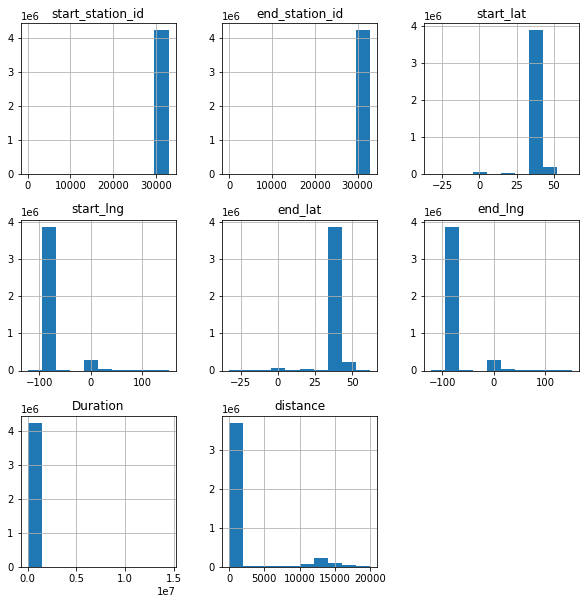

In [32]:
plt.rcParams["figure.figsize"] = (10,10)
df.hist()
plt.show()

### Some useful visualizations 

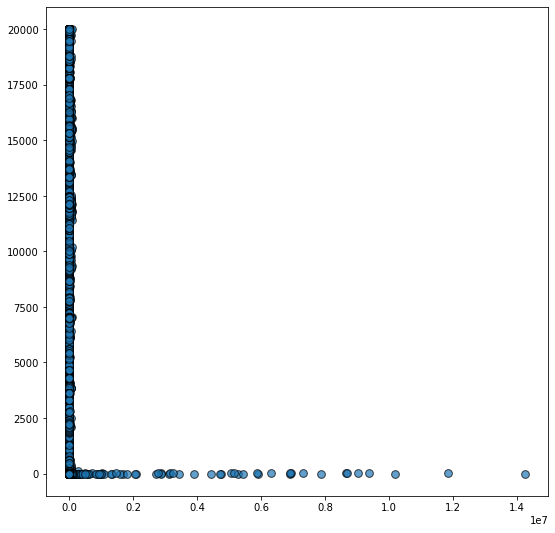

In [15]:
# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))

# Set the data 
x = df[(df.member_casual=='member')]['Duration']

y = df[(df.member_casual=='member')]['distance']

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 10, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="k", lw=2.5);

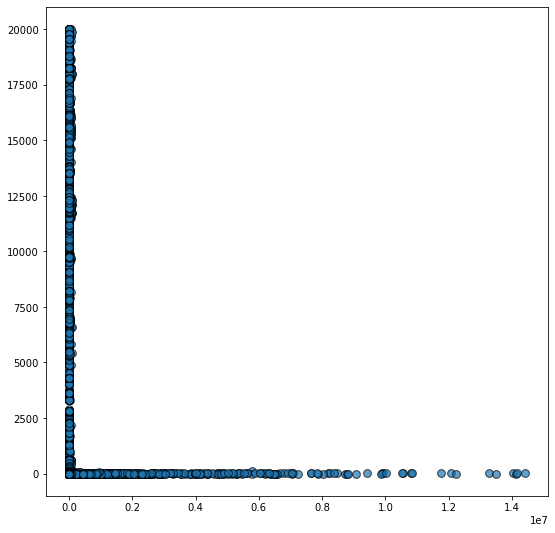

In [16]:
# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))

# Set the data 
x = df[(df.member_casual=='casual')]['Duration']

y = df[(df.member_casual=='casual')]['distance']

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 10, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="k", lw=2.5);